In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.24/06


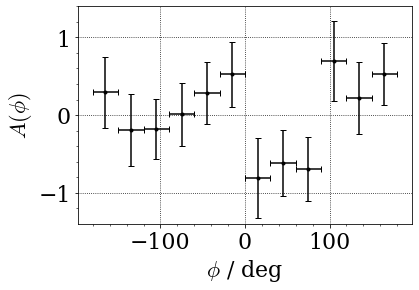

In [11]:
final_df=pd.read_csv('eta_data.csv')
i=8
j=0
x=final_df['phi']
dx=1/2*final_df['bin_phi']
y=final_df[f'A_{i,j}']
dy=final_df[f'dA_{i,j}']
fig, ax = plt.subplots()
ax.errorbar(x,y,xerr=dx,yerr=dy,fmt='.')
ax.set_xlabel("$\phi$ / deg")
ax.set_ylabel("$A(\phi)$")
ax.set_ylim([-1.4,1.4])
plt.show()

In [56]:
#this is my framework for bayesian fits and pretty plots
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=data
        self.stan_data={'n':len(self.data['x'].values),
             'x':list(self.data['x'].values),
             'y':list(self.data['y'].values),
           'dy':list(self.data['dy'].values)}
        self.stanfile=stanfile
        self.x=self.data['x']
        self.y=self.data['y']
        self.dy=self.data['dy']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples)
    #funtion w/o phase
    def f(self,x,a,b):
            return a*np.cos(2*np.pi/180.*(-45-x))
    #function with phase
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    #chi2 parameters of fitted data
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['x'].values,self.data['y'].values,
                                   sigma=self.data['dy'].values)
            return popt,pcov
    #print stan code
    def stan_code(self):
        return self.model.code()
    #get pd dataframe of samples
    def samples_df(self):
        return self.fitobj.draws_pd()
    #calculate waic for given samples and log likelihoods
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=np.array([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['x']))])
        lpd=np.array([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['x']))])
        elpd=lpd-pwaic
        se=np.sqrt(len(self.x)*np.var(elpd,ddof=1))
        return sum(elpd), se, elpd
    #plot posterior predictive distributions
    def plot_ppd(self,save,fitfunc,width=.5):
        samples=self.fitobj.draws_pd()
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
        ax.set_ylabel('$p(y_{rep}|y)$')
        ax.xaxis.set_ticks_position("top")
        ax.grid(which='minor',color='grey',lw='.4')
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['x']),np.max(self.data['x']),200)
        params=self.get_chisqpars(fitfunc)[0]
        yfit=fitfunc(xx,*params)
        ax.errorbar(x=self.data['x'],y=self.data['y'],yerr=self.data['dy'],fmt='.',label='Data points')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='r')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))],np.array(self.x),
                         showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('red')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])for i in range(len(self.data['x']))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.plot(self.data['x'],pvalue,'.')
        ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
        ax1.set_xlabel('x')
        ax1.set_ylabel('$T(y_{rep}>y)$')
        ax1.set_ylim([0,1])
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        if (save==True):
            plt.savefig(f'./ppd_{len(params)}_params.pdf',format='pdf',bbox_inches='tight',dpi=1000)
    # plot posterior distributions of desired parameters, indicate chi2 fit value(s) and error(s)
    def plot_posterior(self,params,func,save=False):
        samples=self.fitobj.draws_pd()
        chi2pars=self.get_chisqpars(function=func)
        fig, (ax)=plt.subplots(ncols=1,nrows=len(params)+1,dpi=1000)
        #print(len(params))
        for i in range(len(params)):
            #cosmetics
            ax[i].set_xlabel(params[i],fontsize=10)
            ax[i].set_ylabel('Frequency',fontsize=10)
            ax[i].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
            ax[i].tick_params(axis='x', which='both',labelsize=10)
            #plot data
            ax[i].errorbar(x=chi2pars[0][i],y=0,xerr=np.sqrt(chi2pars[1][i,i]),label='$\chi^2$-fit',color='blue')
            #plot posterior kde distribution bc pretty
            sns.distplot(samples[params[i]],hist=True,kde=True,ax=ax[i],kde_kws={'bw':0.35})
            kde_curve = ax[i].lines[0]
            x = np.array(kde_curve.get_xdata())
            y = np.array(kde_curve.get_ydata())
            maxpos = y.argmax()
            maxx=x[maxpos]
            counts, bins = np.histogram(samples[params[i]],bins=20)
            mean=np.mean(samples[params[i]])
            sd=np.std(samples[params[i]])
            #mids = 0.5*(bins[1:] + bins[:-1])
            #probs = counts / np.sum(counts)
    
            #mean = np.sum(probs * mids)  
            #sd = np.sqrt(np.sum(probs * (mids - mean)**2))
            #indicate chi2 values
            ax[i].axvline(x=maxx,ymin=0,ymax=1,linewidth='.5',label='MPV',color='red')
            ax[i].axvline(x=mean,ymin=0,ymax=1,linewidth='.5',label='$\mu\pm 1\sigma$',color='red',linestyle='dashed')
            ax[i].axvline(x=mean-sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
            ax[i].axvline(x=mean+sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
            #cosmetics and legend
            plt.legend(bbox_to_anchor=(1,2),fontsize=10)
            plt.subplots_adjust(hspace=1)
        if(save):
            fig.savefig(f'./posterior_{len(params)}_params.pdf',format='pdf',dpi=1000)

    # function to plot the posterior distributions as is     
    def plot_trace(self,params,save=False):
        samples=self.fitobj.draws_pd()
        fig, (ax)=plt.subplots(ncols=2,nrows=len(params),dpi=1000)
        #print(ax.shape)
        ls=['solid','dotted','dashed','dashdot']
        for i in range(len(params)):
            ax[i][0].grid(visible=False,axis='y')
            ax[i][0].set_xlabel(params[i],fontsize=10)
            ax[i][0].set_ylabel('Frequency',fontsize=10)
            ax[i][1].set_xlabel('iteration',fontsize=10)
            ax[i][1].set_ylabel(params[i],fontsize=10)
            for k in range(4):
                sns.kdeplot(samples[params[i]][k*1000:(k+1)*1000],ax=ax[i][0],linestyle=ls[k],color='black',
                            linewidth=.5,bw=0.35)
                ax[i][1].plot(np.arange(0,len(samples[params[i]])/4),
                              samples[params[i]][k*1000:(k+1)*1000],ls=ls[k],color='black',alpha=.7,linewidth=.5)
                for j in (0,1):
                    ax[i][j].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
                    #ax[i][j].set_title(params[i])
                    ax[i][j].tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(hspace=1)
        #fig.set_size_inches(8.29,1*len(params))
def find_y_for_x(x, y, value):
    for i in range(len(x)):
        if x[i]<= value and x[i+1]>= value:
            return y[i]
            break
        
#calculate savage dickey density ratio = Bayes factor
def plot_sddr(samples,fixpar,saveas):#this is the model with one parameter more
    fig, ax =plt.subplots(dpi=1000)
    #define prior data and get posterior using kde
    x=np.linspace(-.5,.5,1000)
    def prior(x):
        return stats.norm.pdf(x,0,np.pi)
    priorval=prior(fixpar)
    sns.distplot(samples,hist=True,kde=True,ax=ax,kde_kws={'bw':0.35},label='$p(c|y,M_1)$')
    kde_curve = ax.lines[0]
    xx = kde_curve.get_xdata()
    y = kde_curve.get_ydata()
    postval=find_y_for_x(xx,y,fixpar)
    #plot
    ax.plot(x,prior(x),label='$\pi(c|M_1)$')
    ax.vlines(fixpar,0,np.max(y),linestyle='--',color='peachpuff',label='BF={:.2f}'.format(postval/priorval))
    ax.legend(bbox_to_anchor=(1,1))
    fig.savefig(saveas,format='pdf',dpi=1000,bbox_inches='tight')
def elpd_diff(fit,fit1):
    elpd=np.array(fit.waic()[2])
    elpd1=np.array(fit1.waic()[2])
    return np.abs(sum(elpd)-sum(elpd1)),np.sqrt(len(fit.x)*np.var(elpd-elpd1))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


<Figure size 432x288 with 0 Axes>

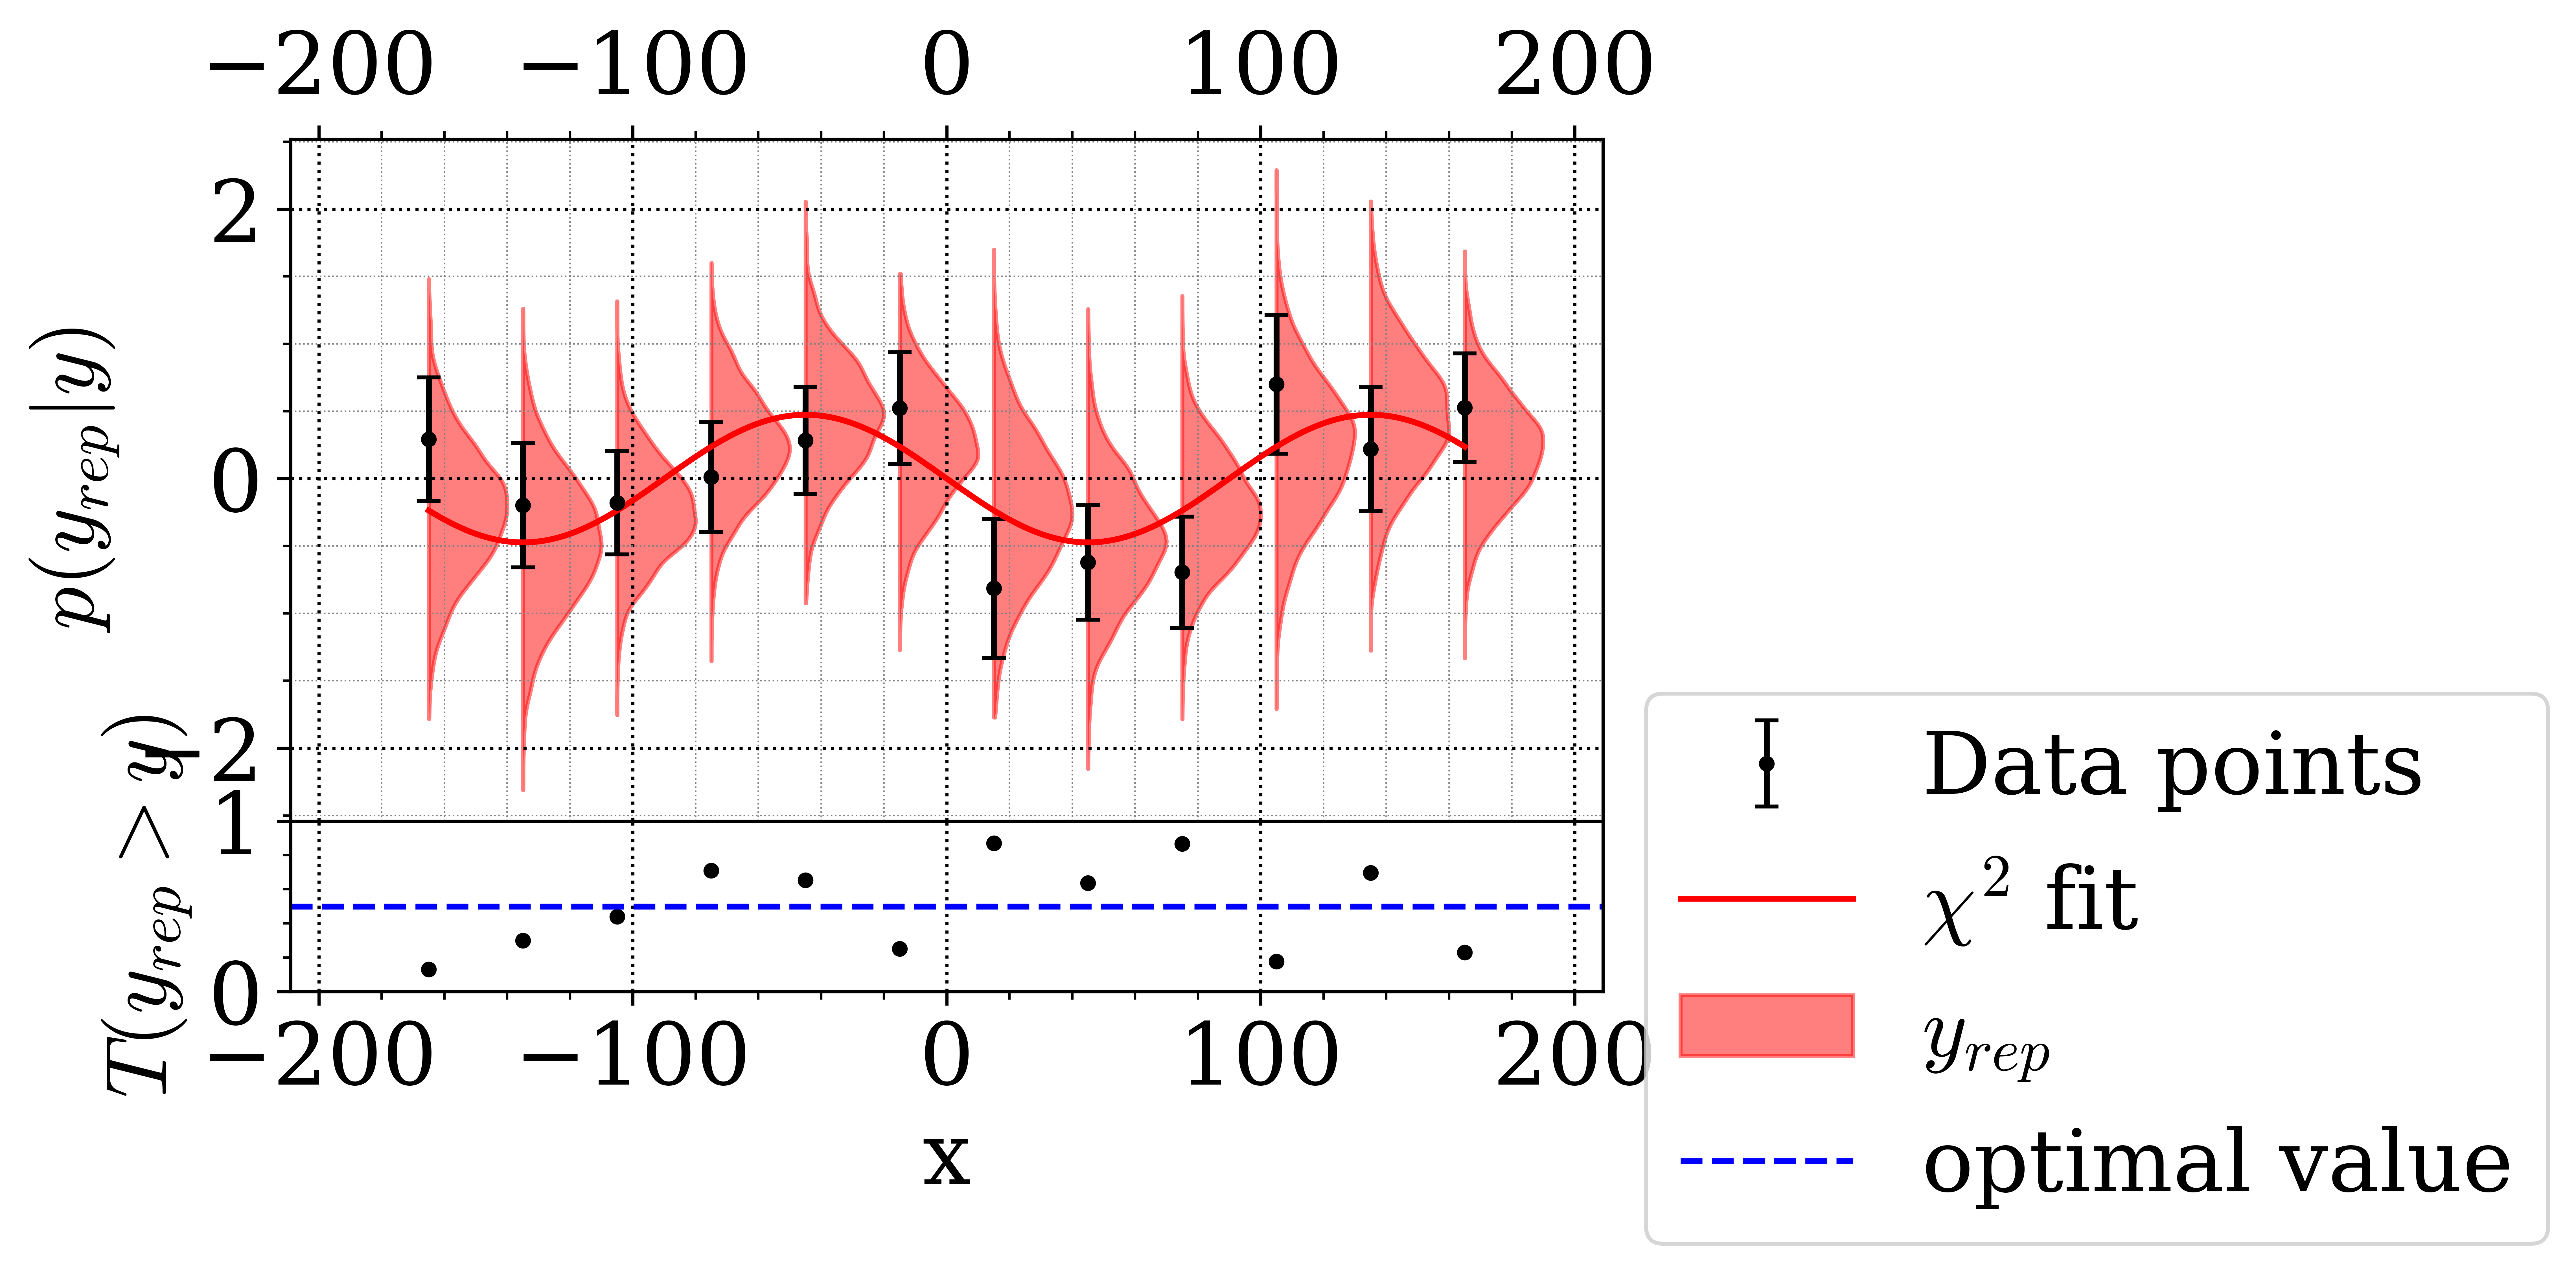

In [60]:
for i in range(8,9):# 11 energy bins
    #fig, ax = plt.subplots(3,4,sharex='col',sharey='row')
    plt.subplots_adjust(hspace=0,wspace=0)
    sigma_list=[]
    for j in range(0,1): # 12 bins in costheta
        df_tmp=final_df[['phi',f'A_{i,j}',f'dA_{i,j}']]
        df_tmp=df_tmp.rename(columns={'phi': 'x', f'A_{i,j}': 'y', f'dA_{i,j}': 'dy'})
        #print(df_tmp.head())
        fit=bayesian_fit(data=df_tmp,stanfile='stan_file.stan',nsamples=1000)
        sigma=fit.samples_df()['a']
        sigma_list.append(sigma)
        #fit.plot_posterior(params=['a'],func=fit.f,save=False)
        fit.plot_ppd(save=False,fitfunc=fit.f,width=50)



12


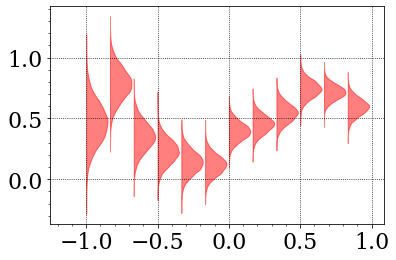

In [34]:
fig,ax = plt.subplots()
print(len(np.arange(-1,1,2/12)))
vp=ax.violinplot(sigma_list,np.arange(-1,1,2/12),
                         showmeans=False, showextrema=False, showmedians=False,widths=0.3)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    b.set_color('red')

AttributeError: 'AxesSubplot' object has no attribute 'subplots'

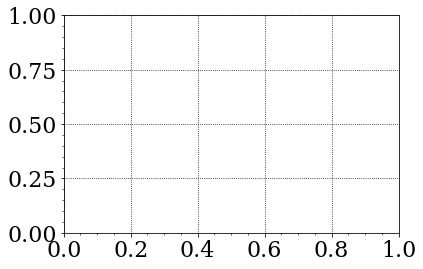

In [51]:
fig,ax=plt.subplots()
subaxes=ax.subplots(2,1)